In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
import numpy as np
import pandas as pd

In [2]:
def charge(mol, at_ind):
    AllChem.ComputeGasteigerCharges(mol)
    charges=mol.GetAtomWithIdx(at_ind).GetDoubleProp('_GasteigerCharge')
    return charges

In [3]:
#soc stands for sum over charge
def soc(smile, startAtom):
    mol=Chem.MolFromSmiles(smile)
    Q0=charge(mol, startAtom)
    #print(Q0)
    
    atom1 = mol.GetAtomWithIdx(startAtom)
    radii1=[x.GetIdx() for x in atom1.GetNeighbors()]
    Q1=sum([charge(mol, i) for i in radii1])
    #print(Q1)
    
    initialRadii2=[]
    for i in radii1:
        atom2=mol.GetAtomWithIdx(i)
        atIndRad2=[x.GetIdx() for x in atom2.GetNeighbors()]
        initialRadii2.append(atIndRad2)
    radii2  = set([val for sublist in initialRadii2 for val in sublist])
    radii2.remove(startAtom)
    numElement=len(radii2) #just to check how many atoms are there in radii2
    Q2=sum([charge(mol, i) for i in radii2])
    return Q0, Q1, Q2

In [4]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [5]:
def heteroAtomIndexFinder(smile):
    heteroList=[7, 8, 15, 16]
    heteroIndex=[]
    mol=Chem.MolFromSmiles(smile)
    for i in heteroList:
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum()==i:
                heteroIndex.append(atom.GetIdx())
                
    aromaticity=[]
    ringInfo=[]
    hybridisation=[]
    atomicNum=[]
    Q0=[]
    Q1=[]
    Q2=[]
    numHs=[]
    for i in heteroIndex:
        atom = mol.GetAtomWithIdx(i)
        aromaticity.append(atom.GetIsAromatic())
        ringInfo.append(atom.IsInRing())
        hybridisation.append(atom.GetHybridization())
        atomicNum.append(atom.GetAtomicNum())
        Q0.append(soc(smile, i)[0])
        Q1.append(soc(smile, i)[1])
        Q2.append(soc(smile, i)[2])
        numHs.append(atom.GetTotalNumHs())
    return aromaticity, ringInfo, hybridisation, atomicNum, Q0, Q1, Q2, numHs

In [6]:
def feature_vector(smile):
    result=heteroAtomIndexFinder(smile)
    mat1=np.array(list(result))
    transposed_mat=mat1.transpose()
    feat_vec=list(transposed_mat.flatten())
    return feat_vec

In [7]:
import os
os.chdir('C:/Users/sunoj/Downloads')

In [8]:
df=pd.read_csv('Bisphos_curated.csv')

In [9]:
data=[]
for i in df['CanonicalSMILES']:
    data.append(feature_vector(i))

In [10]:
df_data=pd.DataFrame(data)

In [11]:
feature=['feat'+str(i) for i in range(80)]

In [12]:
df_data.columns=feature

In [13]:
df_data=df_data.fillna(0)

In [23]:
df_data.head(3)

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat70,feat71,feat72,feat73,feat74,feat75,feat76,feat77,feat78,feat79
0,0.0,0.0,4.0,8.0,-0.381373,0.094205,-0.050429,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,4.0,15.0,-0.043965,-0.058985,-0.236776,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.0,15.0,-0.099989,-0.069436,-0.214019,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


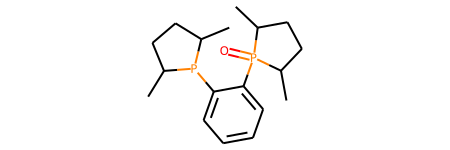

In [86]:
mol=Chem.MolFromSmiles(df['CanonicalSMILES'][42])
mol

In [80]:
features_order=['aromaticity', 'ringInfo', 'hybridisation', 'atomicNum', 'Q0', 'Q1', 'Q2', 'numHs']

In [85]:
df_data.iloc[41:43, 8:25]

,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23,feat24
41,0.0,1.0,4.0,15.0,-0.090980,-0.01796,-0.191564,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0
42,0.0,1.0,4.0,15.0,-0.068697,-0.05171,-0.242000,0.0,0.0,1.0,4.0,15.0,0.12108,-0.270393,-0.259873,0.0,0.0


In [75]:
df['CanonicalSMILES'][50]

'C1=CC=C2C(=C1)P3C4=CC=CC=C4P2C5=CC=CC=C53'